In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [39]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [40]:
print(tf.__version__)

2.12.0


In [41]:
tf.random.set_seed(42)
np.random.seed(42)

In [42]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(511, 15) (146, 15) (47, 15)


In [43]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_14,EMA_7,EMA_14,RSI,Stoch_RSI,Upper_BB,Lower_BB,MACD
0,0.304276,0.307328,0.307513,0.309186,0.309186,0.057216,0.321826,0.347362,0.326060,0.339517,0.222696,0.000000,0.361351,0.380083,0.360559
1,0.309417,0.297561,0.294679,0.290280,0.290280,0.072710,0.315031,0.342962,0.319083,0.334126,0.250482,0.073054,0.356682,0.374275,0.344891
2,0.290839,0.280817,0.270994,0.270765,0.270765,0.098240,0.306619,0.336308,0.308623,0.326587,0.149018,0.000000,0.357109,0.362171,0.322469
3,0.270710,0.314053,0.274248,0.315248,0.315248,0.145798,0.304551,0.333686,0.312696,0.326650,0.380772,0.510438,0.355915,0.360309,0.330462
4,0.315963,0.310705,0.317946,0.319157,0.319157,0.064434,0.306098,0.332838,0.316798,0.327280,0.452657,0.668763,0.353842,0.359191,0.339719


## `DataWindow` class 

In [44]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [45]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [46]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [47]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [48]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [49]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

5/5 [==============================] - 0s 2ms/step - loss: 0.0614 - mean_absolute_error: 0.1353


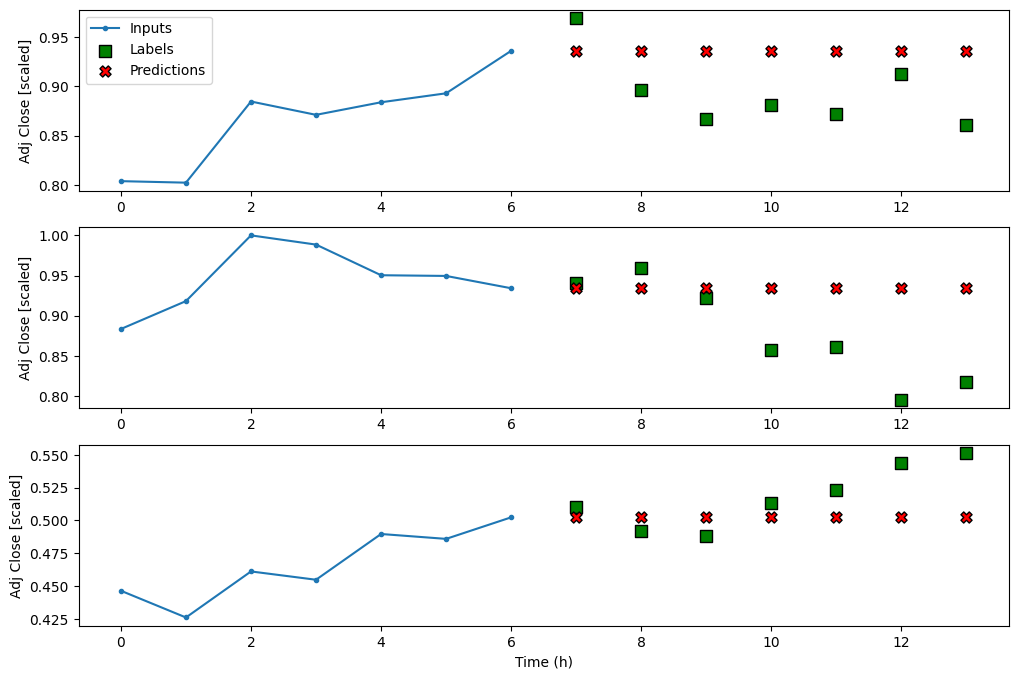

In [50]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [51]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [52]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

5/5 [==============================] - 0s 1ms/step - loss: 0.0626 - mean_absolute_error: 0.1406


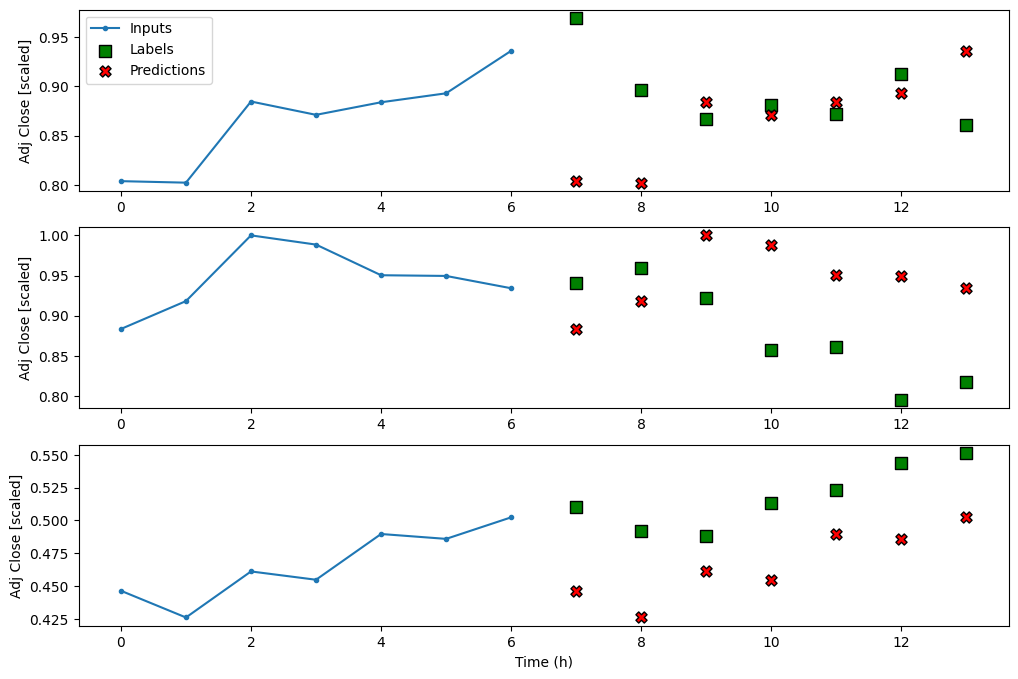

In [53]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [54]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1812 - mean_absolute_error: 0.3435 - val_loss: 0.0126 - val_mean_absolute_error: 0.0955
Epoch 2/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0997 - mean_absolute_error: 0.2467 - val_loss: 0.0042 - val_mean_absolute_error: 0.0510
Epoch 3/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0501 - mean_absolute_error: 0.1770 - val_loss: 0.0027 - val_mean_absolute_error: 0.0460
Epoch 4/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0253 - mean_absolute_error: 0.1302 - val_loss: 0.0046 - val_mean_absolute_error: 0.0599
Epoch 5/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0150 - mean_absolute_error: 0.1022 - val_loss: 0.0068 - val_mean_absolute_error: 0.0730
Epoch 6/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.0080 - mean_absolute_error: 0.0799


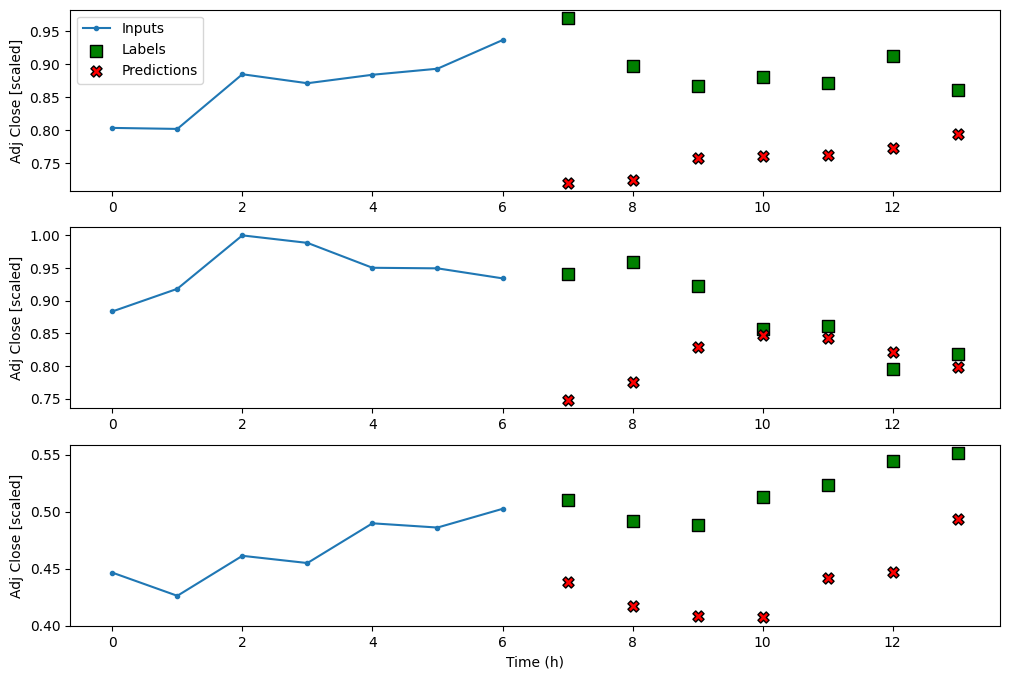

In [55]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [56]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 1s 10ms/step - loss: 0.1494 - mean_absolute_error: 0.3060 - val_loss: 0.0036 - val_mean_absolute_error: 0.0511
Epoch 2/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0202 - mean_absolute_error: 0.1224 - val_loss: 0.0121 - val_mean_absolute_error: 0.1010
Epoch 3/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0096 - mean_absolute_error: 0.0796 - val_loss: 0.0023 - val_mean_absolute_error: 0.0398
Epoch 4/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0063 - mean_absolute_error: 0.0652 - val_loss: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0551 - val_loss: 0.0015 - val_mean_absolute_error: 0.0316
Epoch 6/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0049 - mean_absolute_error: 0.0524 - val_loss: 0.0016 - val_mean_absolute_error: 0.0317
Epoch 7/1000
5/

## LSTM model 

In [57]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 3s 32ms/step - loss: 0.1906 - mean_absolute_error: 0.3540 - val_loss: 0.0126 - val_mean_absolute_error: 0.0938
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0834 - mean_absolute_error: 0.2173 - val_loss: 0.0233 - val_mean_absolute_error: 0.1260
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0437 - mean_absolute_error: 0.1672 - val_loss: 0.0146 - val_mean_absolute_error: 0.1008
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0321 - mean_absolute_error: 0.1338 - val_loss: 0.0058 - val_mean_absolute_error: 0.0644
Epoch 5/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0247 - mean_absolute_error: 0.1158 - val_loss: 0.0044 - val_mean_absolute_error: 0.0561
Epoch 6/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0185 - mean_absolute_error: 0.0984 - val_loss: 0.0027 - val_mean_absolute_error: 0.0431
Epoch 7/1000
16

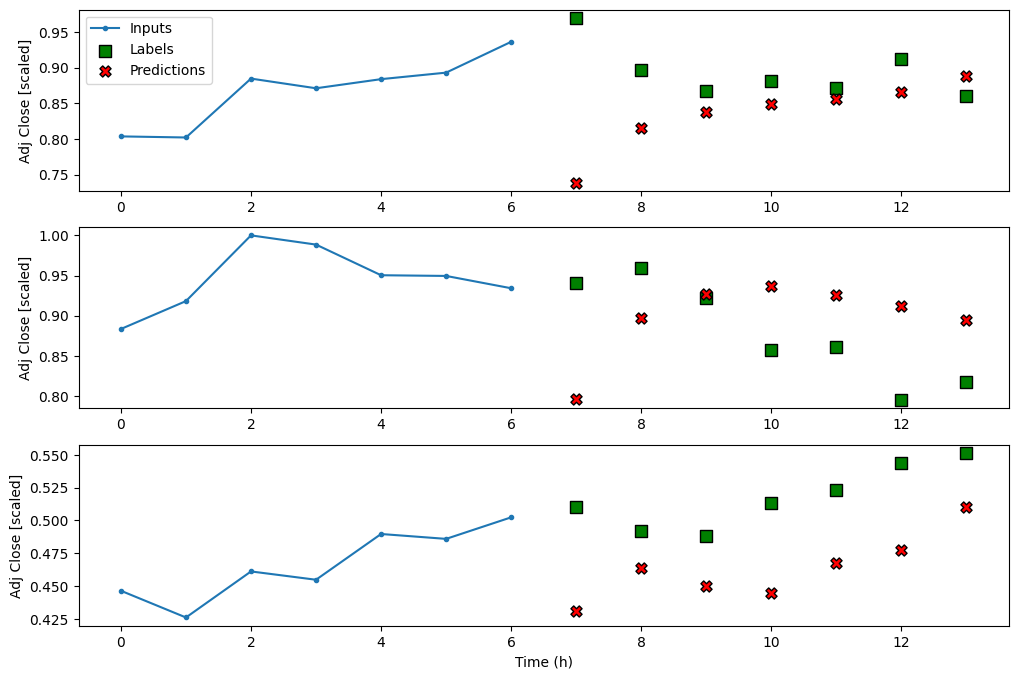

In [58]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [59]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [60]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 1s 10ms/step - loss: 0.1839 - mean_absolute_error: 0.3429 - val_loss: 0.0065 - val_mean_absolute_error: 0.0634
Epoch 2/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0425 - mean_absolute_error: 0.1593 - val_loss: 0.0382 - val_mean_absolute_error: 0.1820
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0171 - mean_absolute_error: 0.1109 - val_loss: 0.0058 - val_mean_absolute_error: 0.0674
Epoch 4/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0095 - mean_absolute_error: 0.0801 - val_loss: 0.0048 - val_mean_absolute_error: 0.0610
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0646 - val_loss: 0.0016 - val_mean_absolute_error: 0.0328
Epoch 6/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0054 - mean_absolute_error: 0.0561 - val_loss: 0.0016 - val_mean_absolute_error: 0.0315
Epoch 7/1000
16

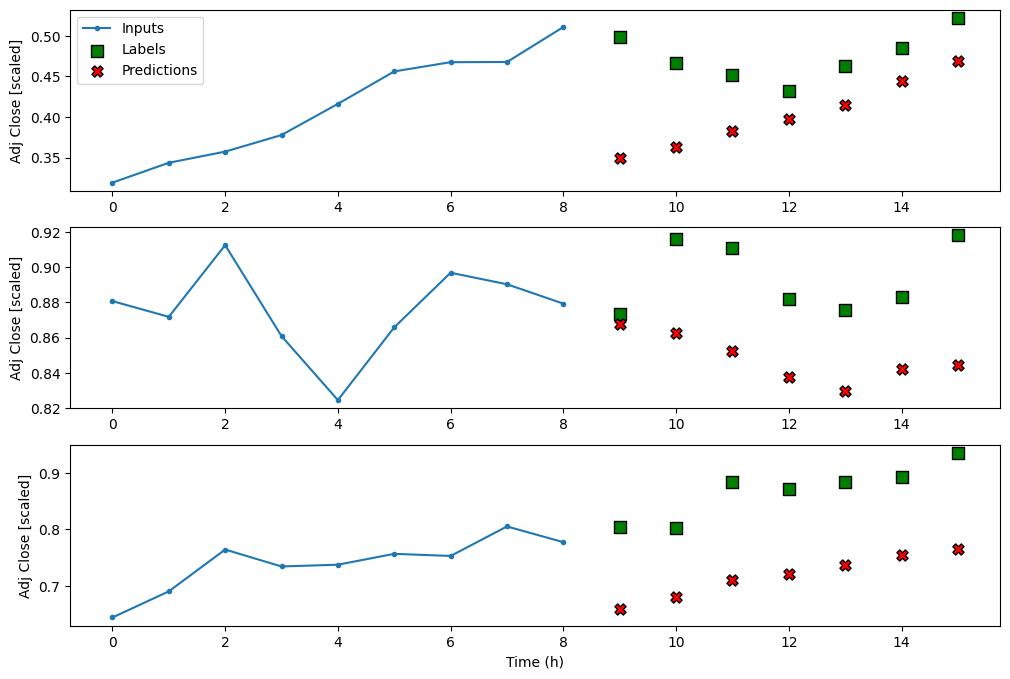

In [61]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [62]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 2s 27ms/step - loss: 0.1862 - mean_absolute_error: 0.3471 - val_loss: 0.0092 - val_mean_absolute_error: 0.0782
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0641 - mean_absolute_error: 0.1956 - val_loss: 0.0408 - val_mean_absolute_error: 0.1694
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0348 - mean_absolute_error: 0.1475 - val_loss: 0.0047 - val_mean_absolute_error: 0.0559
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0217 - mean_absolute_error: 0.1034 - val_loss: 0.0040 - val_mean_absolute_error: 0.0524
Epoch 5/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0140 - mean_absolute_error: 0.0831 - val_loss: 0.0033 - val_mean_absolute_error: 0.0480
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0705 - val_loss: 0.0025 - val_mean_absolute_error: 0.0398
Epoch 7/1000
16

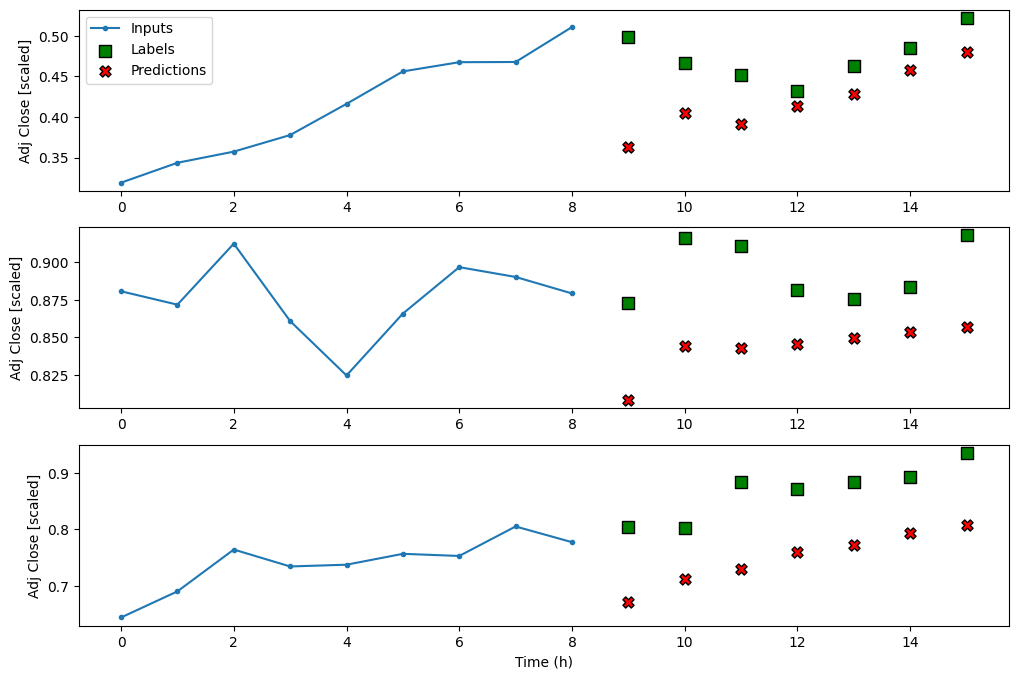

In [63]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [64]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [65]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 2s 23ms/step - loss: 0.1184 - mean_absolute_error: 0.2619 - val_loss: 0.0167 - val_mean_absolute_error: 0.1051
Epoch 2/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0264 - mean_absolute_error: 0.1309 - val_loss: 0.0082 - val_mean_absolute_error: 0.0747
Epoch 3/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0123 - mean_absolute_error: 0.0833 - val_loss: 0.0051 - val_mean_absolute_error: 0.0578
Epoch 4/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0736 - val_loss: 0.0044 - val_mean_absolute_error: 0.0514
Epoch 5/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0073 - mean_absolute_error: 0.0656 - val_loss: 0.0034 - val_mean_absolute_error: 0.0455
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_error: 0.0588 - val_loss: 0.0026 - val_mean_absolute_error: 0.0400
Epoch 7/1000
16

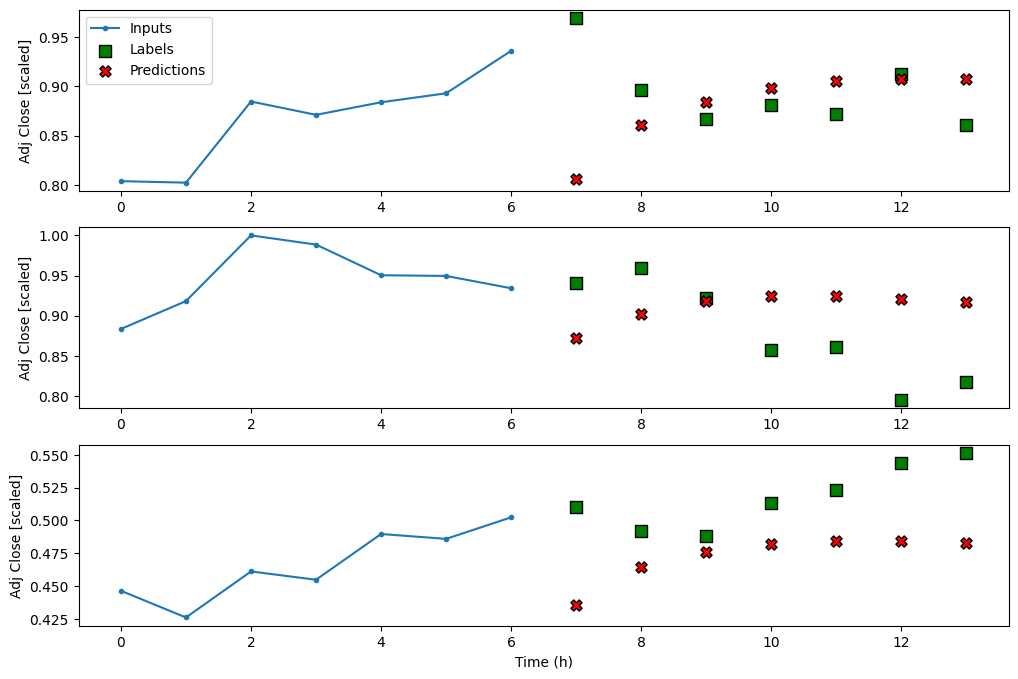

In [66]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

In [67]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
16/16 [==============================] - 2s 32ms/step - loss: 0.1925 - mean_absolute_error: 0.3534 - val_loss: 0.0096 - val_mean_absolute_error: 0.0791
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0696 - mean_absolute_error: 0.2026 - val_loss: 0.0460 - val_mean_absolute_error: 0.1813
Epoch 3/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0376 - mean_absolute_error: 0.1541 - val_loss: 0.0056 - val_mean_absolute_error: 0.0626
Epoch 4/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0215 - mean_absolute_error: 0.1060 - val_loss: 0.0036 - val_mean_absolute_error: 0.0500
Epoch 5/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0127 - mean_absolute_error: 0.0800 - val_loss: 0.0030 - val_mean_absolute_error: 0.0452
Epoch 6/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0089 - mean_absolute_error: 0.0681 - val_loss: 0.0026 - val_mean_absolute_error: 0.0392
Epoch 7/1000
16

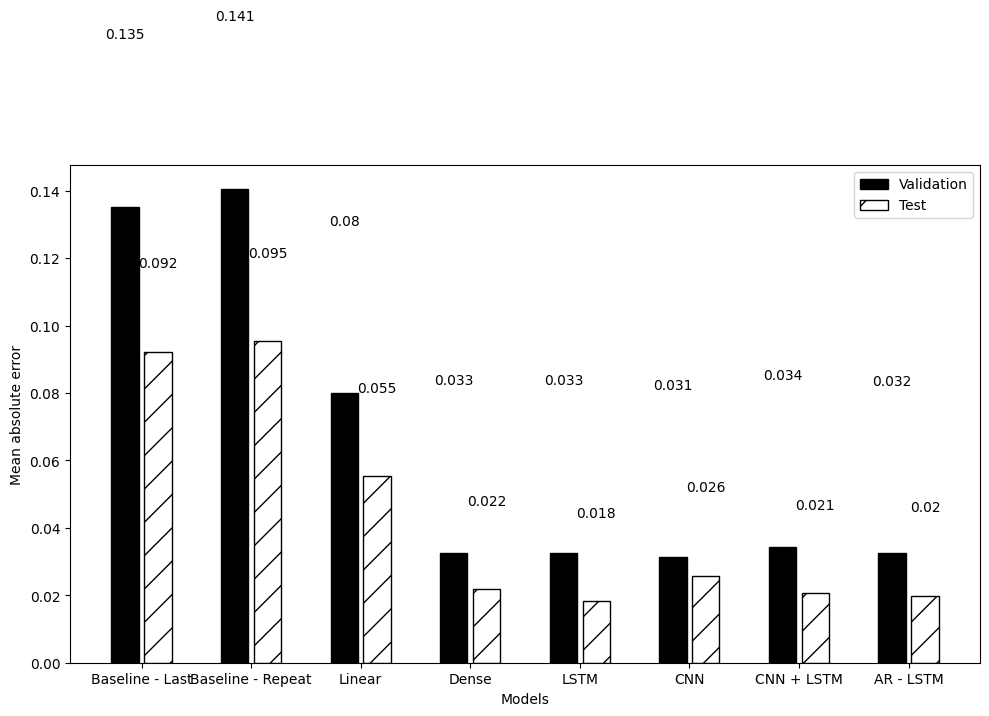

In [68]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.05, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.025, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)